## Classificador hierárquico para características morfométricas de núcleo de células cervicais 

In [22]:
import numpy as np
import pandas as pd 
from math import sqrt
import os
import sys
import csv
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow 
from skimage import morphology, measure
from skimage.draw import polygon, polygon_perimeter
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis

import pyefd
from pyefd import elliptic_fourier_descriptors, normalize_efd

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import feature_selection as fs
from sklearn import preprocessing

from datetime import datetime

# pay attention to capitalization below!
from spFSR import SpFSR
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE, BorderlineSMOTE

from itertools import cycle
from random import randint
from random import sample

import xgboost as xgb 

import functions, shapeFeatures

In [23]:
Bethesda_classes = {'Normal':0, 'ASC-US':1, 'ASC-H':2, 'LSIL':3,'HSIL':4, 'Invasive Carcinoma':5} 
Bethesda_idx_classes = {0: 'Normal', 1:'ASC-US', 2:'ASC-H', 3:'LSIL',4: 'HSIL', 5:'Invasive Carcinoma'} 

### Features:

In [24]:
len(functions.list_all_features(20)), len(functions.list_all_nucleus_features(20)), len(functions.list_all_cyto_features(20)), len(functions.list_all_EFD_features(20))


(200, 98, 98, 154)

### Lê arquivo (features):

In [25]:
N_EFD_COEFFS = 20

In [26]:
df = pd.read_csv('dataCRIC.csv', sep='|', header=0)
df = shapeFeatures.normalize_dataset(df, n_efd_coeffs= N_EFD_COEFFS)
 

In [27]:
df

,image_id,cell_id,areaN,eccenN,extentN,periN,maxAxN,minAxN,compacN,circuN,...,efdC73,efdC74,efdC75,efdC76,efdC77,ratio_NC,ratio_NC_per,ratio_NC_hArea,nucleus_position,bethesda
0,1.0,14796.0,0.007403,0.606414,0.842276,0.031326,0.036711,0.083827,0.024126,0.863522,...,0.156532,0.321490,0.859931,0.382225,0.302311,0.017236,0.115646,0.016730,0.099098,0.0
1,1.0,14797.0,0.009371,0.541484,0.808102,0.035945,0.039493,0.095649,0.018763,0.891071,...,0.150931,0.317850,0.859539,0.369221,0.299938,0.010656,0.089517,0.010168,0.121456,0.0
2,1.0,14798.0,0.007275,0.313794,0.884418,0.029457,0.025365,0.097062,0.018895,0.890378,...,0.153458,0.315454,0.861978,0.367980,0.302076,0.007400,0.073961,0.006897,0.043773,0.0
3,1.0,14799.0,0.010570,0.489270,0.778201,0.040199,0.040900,0.103428,0.021001,0.879403,...,0.157254,0.319562,0.860312,0.382943,0.303682,0.028309,0.154784,0.027752,0.128927,0.0
4,1.0,14801.0,0.009115,0.296366,0.842276,0.036826,0.031283,0.106376,0.024456,0.861871,...,0.147193,0.314554,0.860292,0.359672,0.300094,0.021569,0.129992,0.020738,0.069245,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,399.0,11539.0,0.028927,0.838629,0.579720,0.094256,0.134656,0.118369,0.041270,0.784196,...,0.152113,0.318217,0.859606,0.370535,0.299400,0.206211,0.149094,0.085315,1.943974,5.0
3229,399.0,11540.0,0.025333,0.874227,0.645532,0.094611,0.135676,0.100778,0.064959,0.692461,...,0.150010,0.322108,0.859366,0.375599,0.300755,0.245537,0.247086,0.136756,0.916374,5.0
3230,400.0,11535.0,0.017031,0.910741,0.390863,0.092280,0.136377,0.078990,0.131860,0.507358,...,0.153944,0.319972,0.860379,0.372458,0.303245,0.191508,0.471092,0.188343,0.326252,5.0
3231,400.0,11536.0,0.020797,0.949322,0.528816,0.105709,0.169029,0.065965,0.137720,0.494794,...,0.151898,0.320620,0.859608,0.370771,0.299599,0.111823,0.078186,0.023058,3.177247,5.0


In [28]:
# Separa dados por classe de maneira balanceada:
data_normal = df[df['bethesda'] == 0].copy()
data_normal.set_index((i for i in range(data_normal.shape[0])), inplace=True)

data_ascus = df[df['bethesda'] == 1].copy()
data_ascus.set_index((i for i in range(data_ascus.shape[0])), inplace=True)

data_asch = df[df['bethesda'] == 2].copy()
data_asch.set_index((i for i in range(data_asch.shape[0])), inplace=True)

data_lsil = df[df['bethesda'] == 3].copy()
data_lsil.set_index((i for i in range(data_lsil.shape[0])), inplace=True)

data_hsil = df[df['bethesda'] == 4].copy()
data_hsil.set_index((i for i in range(data_hsil.shape[0])), inplace=True)

data_car = df[df['bethesda'] == 5].copy()
data_car.set_index((i for i in range(data_car.shape[0])), inplace=True)

print("--- Totais por classe --- ")               
print("Normal...: ", data_normal.values.shape[0])               
print("ASC-Us...: ", data_ascus.values.shape[0])               
print("ASC-H....: ", data_asch.values.shape[0])               
print("LSIL.....: ", data_lsil.values.shape[0])               
print("HSIL.....: ", data_hsil.values.shape[0])               
print("Carcinoma: ", data_car.values.shape[0]) 
 

--- Totais por classe --- 
Normal...:  862
ASC-Us...:  286
ASC-H....:  536
LSIL.....:  598
HSIL.....:  874
Carcinoma:  77


#### Gera dataframes: dados (data), classes (target) e Ids (image/cell)

In [29]:
# Monta base (data, target, image/cells ids)
data, target, image_cells_ids= functions.get_database_data_targe_ids(data_normal, data_ascus, 
                       data_lsil, data_asch, data_hsil,data_car,
                       functions.list_all_nucleus_features(N_EFD_COEFFS))
 

In [30]:
## Parâmetros resultantes de gridsearch dos modelos (tuning.ipynb)
svm_param =  {'C': 100, 'kernel': 'linear'}
rf_param = {'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 50}
xgb_param = {'learning_rate': 0.1, 'n_estimators': 86, 'max_depth': 9, 'min_child_weight':1,
              'gamma':0, 'subsample':0.9, 'colsample_bytree':0.7, 'reg_alpha': 0.001}

In [31]:
classifiers = ['SVM', 'RF', 'XGBoost']
params = [svm_param, rf_param, xgb_param]
features = functions.list_all_nucleus_features(N_EFD_COEFFS)
print(f'Nº total de de features: {len(features)}')

Nº total de de features: 98


In [32]:
#### Features resultantes seleção prévia (Vide arquivos <features_selection>.ipynb)

#best_features_spfsr_1 =  ['periN', 'eN', 'mrdN', 'maxAxN', 'ardN', 'compacN', 'circuN', 'fdN']
best_features_MI_1 =   ['mrdN', 'eN', 'maxAxN', 'periN', 'ardN', 'hAreaN', 'areaN',
                        'equidiaN', 'fdN', 'riN', 'circuN', 'compacN', 'minAxN', 'convexN',
                        'extentN', 'elonN', 'efdN72', 'kN', 'eccenN', 'raN', 'efdN74',
                        'efdN76', 'efdN77', 'efdN70', 'efdN69', 'efdN71', 'efdN75',
                        'efdN61', 'solidN', 'efdN68']
#best_features_spfsr_2 =  ['fdN','periN','hAreaN','areaN', 'equidiaN', 'convexN', 'solidN',
#                          'efdN60', 'efdN16', 'efdN36', 'ardN', 'efdN59', 'efdN11', 'efdN72',
#                          'efdN52']  
best_features_MI_2 =   ['equidiaN', 'areaN', 'fdN', 'hAreaN', 'riN', 'periN', 'ardN',
                        'minAxN', 'maxAxN', 'mrdN', 'eN', 'efdN71', 'efdN70', 'efdN75',
                        'efdN74', 'elonN', 'efdN63', 'efdN66', 'efdN38', 'efdN58',
                        'efdN55', 'convexN', 'efdN62', 'efdN54', 'efdN46', 'efdN50',
                        'efdN51', 'efdN77', 'efdN4', 'efdN42']
#best_features_spfsr_3 =   ['solidN', 'circuN', 'compacN', 'efdN7', 'efdN76', 'efdN40',
#                           'efdN58', 'raN', 'convexN', 'efdN71', 'extentN', 'sdnrlN',
#                           'efdN72', 'elonN', 'efdN12', 'efdN55', 'efdN63', 'efdN4',
#                           'efdN17', 'efdN70', 'efdN75', 'efdN3', 'efdN53', 'eccenN',
#                           'efdN37', 'efdN73', 'efdN9', 'efdN10', 'efdN77', 'efdN24'] 
best_features_MI_3 =   ['efdN15', 'efdN76', 'mrdN', 'efdN12', 'efdN39', 'extentN',
                        'efdN33', 'efdN25', 'efdN55', 'efdN36', 'riN', 'efdN69',
                        'efdN62', 'efdN2', 'minAxN', 'efdN13', 'efdN41', 'efdN38',
                        'efdN65', 'efdN23', 'efdN19', 'efdN77', 'fdN', 'kN', 'efdN1',
                        'efdN26', 'efdN37', 'ardN', 'efdN6', 'efdN22']
#best_features_spfsr_4 =  ['convexN', 'solidN', 'elonN', 'compacN', 'circuN', 'efdN59',
#                          'efdN46', 'eccenN', 'extentN', 'efdN11', 'efdN51', 'efdN35',
#                          'efdN1', 'efdN23', 'efdN15', 'ardN', 'minAxN', 'efdN24', 'raN',
#                          'fdN' ,'efdN12', 'efdN20', 'efdN3', 'efdN14', 'efdN41', 
#                          'efdN38', 'efdN31', 'efdN54', 'efdN50', 'efdN66']  
best_features_MI_4 =  ['convexN', 'efdN77', 'efdN9', 'extentN', 'efdN20', 'efdN4', 'efdN15',
                       'raN', 'efdN43', 'efdN60', 'efdN33', 'efdN19', 'fdN', 'riN', 'efdN16',
                       'efdN12', 'efdN18', 'efdN10', 'circuN', 'eN', 'compacN', 'eccenN',
                       'maxAxN', 'efdN11', 'efdN40', 'efdN30', 'solidN', 'ardN', 'efdN59',
                       'minAxN']  
 

In [33]:
len(best_features_MI_1), len(best_features_MI_2), len(best_features_MI_3), len(best_features_MI_4)

(30, 30, 30, 30)

## Experiment nº2:   features (only nucleus)

In [34]:
features_desc = "Selected features to nucleus (MI)"
N_FEATURES = 30
N_ITER = 10
 
accs = precs = recs = specs = f1_scores = aucs = np.zeros((3))

labels_list_bin = [] 
roc_curve_list_bin = []

preds_to_conf_matrix_bin= []
preds_to_conf_matrix_ter= []
preds_to_conf_matrix_bet= []

results_bin = pd.DataFrame(columns=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure'])
results_ter = pd.DataFrame(columns=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure'])
results_bet = pd.DataFrame(columns=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure'])

mean_fpr = np.linspace(0, 1, 100)


In [35]:
# Prepara array para registro de predições (classific. binário, ternário e bethesda) separado por algoritmos:
preds_bin = np.ones((data.shape[0],3))*-1
probs_bin = np.zeros((data.shape[0],3,2))
 
preds_ter = np.ones((data.shape[0],3))*-1
probs_ter = np.zeros((data.shape[0],3,2))

preds_bet = np.ones((data.shape[0],3))*-1
probs_bet = np.zeros((data.shape[0],3,2))

In [36]:
le_2 = preprocessing.LabelEncoder()
le_2.fit([1,2])
le_3 = preprocessing.LabelEncoder()
le_3.fit([1,3])
le_4 = preprocessing.LabelEncoder()
le_4.fit([2,4,5])

LabelEncoder()

In [37]:
# Loop principal:  (cross_val )

cv = StratifiedKFold(n_splits=N_ITER, random_state=None)

# Split com rótulos Bethesda para um split estratificado (cada iteração executa todos os classificadores de 1 à 4)
# Separa dados para treino/validação e teste:
for it, (idx_train, idx_test) in enumerate(cv.split(data.values, target['bethesda'].values)):
    print('Iteração número: ', it)

    # Filtra apenas features selecionadas
    X_train = data[best_features_MI_1].values[idx_train]
    y_train = target['binary'].values[idx_train]
    
    X_test = data[best_features_MI_1].values[idx_test]
    y_test = target['binary'].values[idx_test]
                                                   
    ## treino e teste dos modelo (classificador 1):
    for i in range(3):   
        ## Obtem modelo
        model = functions.getModel(params= params[i], classifier = classifiers[i], class_type = 'binary')
        metr, model = functions.fit_model(X_train, y_train, model, cls_type= 1)
        # Predição:
        pred_y = np.empty(len(idx_test)) 
        pred_y = model.predict(X_test)
        prob_y = model.predict_proba(X_test)

        # Registra predições:
        preds_bin[idx_test, i] = pred_y
        probs_bin[idx_test, i] = prob_y
        
        # Registra predições (classicações ternária/bethesda):
        idx_0 = functions.index_pred_from_class(idx_test, pred_y, cls=0)
        preds_ter[idx_0, i] =  preds_bin[idx_0, i]
        probs_ter[idx_0, i] =  probs_bin[idx_0, i] 
        preds_bet[idx_0, i] =  preds_bin[idx_0, i]
        probs_bet[idx_0, i] =  probs_bin[idx_0, i]  

    ##------------ X ------------- 
    ## Classificador 2: lesões de alto/baixo grau
    
    ## Seleciona amostras para treino/teste
    # Treino: seleciona apenas amostras do conjunto de treino para rótulos ternários 1 e 2, filtrando 
    # apenas features selecionadas para o classificador 2
    X_df_train2, y_df_train2 = functions.filter_dataXY(data[best_features_MI_2].loc[idx_train],
                                       target.loc[idx_train], 2)
    X_train2, y_train2 = X_df_train2.values,  y_df_train2.values
        
    for i in range(3):   
        ## Obtem dados para teste de acordo com a predição de cada modelo do classificador 1
        # Teste: filtra amostras de rótulos 1 das predições do classificador 1  
        idx_test2, X_df_test2, y_df_test2 = functions.filter_Xy_from_cls1_to_cls2(data[best_features_MI_2].loc[idx_test],
                                                        target.loc[idx_test], preds_bin[:,i], idx_test)
        
        X_test2, y_test2= X_df_test2.values, y_df_test2.values
 
        ## Obtem modelo
        model = functions.getModel(params= params[i], classifier = classifiers[i], class_type = 'binary')
        metr, model = functions.fit_model(X_train2, y_train2, model, cls_type= 2)
        #print('metricas :', i, metr)
        
        # Predição:
        pred2_y = np.empty(len(idx_test2))
        pred2_y = model.predict(X_test2)
        pred2_y = le_2.inverse_transform(pred2_y)
        #prob_y = model.predict_proba(X_test2)

        # Registra predições:
        preds_ter[idx_test2, i] = pred2_y
        #probs_ter[idx_test2, i] = prob_y        
        
    ##------------ X ------------- 
    ## Classificador 3: ASC-US/LSIL
    
    ## Seleciona amostras para treino/teste
    # Treino: seleciona apenas amostras do conjunto de treino para rótulos bethesda 1 e 3, filtrando 
    # apenas features selecionadas para o classificador 3
    X_df_train3, y_df_train3 = functions.filter_dataXY(data[best_features_MI_3].loc[idx_train],
                                       target.loc[idx_train], 3)
    X_train3, y_train3 = X_df_train3.values,  y_df_train3.values
    
    for i in range(3):   
        ## Obtem dados para teste de acordo com a predição de cada modelo do classificador 2
        # Filtra amostras de rótulos 1 (lesão de baixo grau) das predições dos classificadores 2  
        idx_test3, X_df_test3, y_df_test3 = functions.filter_Xy_from_cls1_to_cls3(data[best_features_MI_3].loc[idx_test],
                                                        target.loc[idx_test], preds_ter[:,i], idx_test)
        
        X_test3, y_test3= X_df_test3.values, y_df_test3.values
 
        ## Obtem modelo
        model = functions.getModel(params= params[i], classifier = classifiers[i], class_type = 'binary')
        metr, model = functions.fit_model(X_train3, y_train3, model, cls_type= 3)
        #print('--metricas Classificador 3 :', i, metr)
        
        # Predição:
        pred3_y = np.empty(len(idx_test3))
        pred3_y = model.predict(X_test3)
        pred3_y = le_3.inverse_transform(pred3_y)
        #prob_y = model.predict_proba(X_test3)

        # Registra predições:
        preds_bet[idx_test3, i] = pred3_y
        #probs_bet[idx_test3, i] = prob_y
        
    ##------------ X ------------- 
    ## Classificador 4: ASC-H/HSIL/Car
    
    ## Seleciona amostras para treino/teste
    # Treino: seleciona apenas amostras do conjunto de treino para rótulos bethesda 2,4,5, filtrando 
    # apenas features selecionadas para o classificador 4
    X_df_train4, y_df_train4 = functions.filter_dataXY(data[best_features_MI_4].loc[idx_train],
                                       target.loc[idx_train], 4)
    X_train4, y_train4 = X_df_train4.values,  y_df_train4.values
    
    
    for i in range(3):   
        ## Obtem dados para teste de acordo com a predição de cada modelo do classificador 2
        # Filtra amostras de rótulos 2(lesão de alto grau) das predições dos classificadores 2  
        idx_test4, X_df_test4, y_df_test4 = functions.filter_Xy_from_cls2_to_cls4(data[best_features_MI_4].loc[idx_test],
                                                        target.loc[idx_test], preds_ter[:,i], idx_test)
        
        X_test4, y_test4= X_df_test4.values, y_df_test4.values
 
        ## Obtem modelo
        model = functions.getModel(params= params[i], classifier = classifiers[i], class_type = 'ternary')
        metr, model = functions.fit_model(X_train4, y_train4, model, cls_type= 4)
        #print('metricas :', i, metr)
        
        # Predição:
        pred4_y = np.empty(len(idx_test4))
        pred4_y = model.predict(X_test4)
        pred4_y = le_4.inverse_transform(pred4_y)
        #prob_y = model.predict_proba(X_test4)

        # Registra predições:
        preds_bet[idx_test4, i] = pred4_y
        #probs_bet[idx_test4, i] = prob_y
 
## Resultados - classificação binária (normal/anormal):
# Calcula curva_roc e AUC:
for i in range(3):   
    prob = probs_bin[:, i, 1]
    fpr, tpr, thresholds = roc_curve(target['binary'].values, prob)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    aucs[i]= auc(mean_fpr, interp_tpr)
    labels_list_bin.append(r"ROC Curve (AUC %s= %0.4f)" % ((classifiers[i]+"- normal/anormal"), aucs[i]))
    roc_curve_list_bin.append((mean_fpr, interp_tpr))
    
    # Calcula e registra métricas p/ fold:
    accs[i] = functions.calc_metric(target['binary'].values, preds_bin[:,i], metric_type='acc', class_type='binary', pos_label=1, classes=[0,1])
    precs[i] = functions.calc_metric(target['binary'].values, preds_bin[:,i], metric_type='prec',class_type='binary')                
    recs[i] = functions.calc_metric(target['binary'].values, preds_bin[:,i], metric_type='rec',class_type='binary')                
    specs[i] = functions.calc_metric(target['binary'].values, preds_bin[:,i], metric_type='spec',class_type='binary')                
    f1_scores[i] = functions.calc_metric(target['binary'].values, preds_bin[:,i], metric_type='f1_score',class_type='binary')        
    # Acumula métricas no dataframe de resultados e agrupa curvas ROC para exibição:
    metrics= {'Model': classifiers[i], 'acc': accs[i], 'prec': precs[i], 'rec': recs[i], 
              'spec': specs[i], 'f1_score': f1_scores[i], 'AUC': aucs[i]}                                      
    functions.fill_line_metrics_CV(classifiers[i], features_desc, i, metrics, results_bin, class_type='1- Normal/Anormal')            
    # Acumula Matrizes de confusão:  https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix
    preds_to_conf_matrix_bin.append((target['binary'].values, preds_bin[:,i], "1. Normal/Anormal -"+str(classifiers[i])))
            
  
## Resultados - classificação ternária (normal/baixo grau/ alto grau)
# Calcula métricas e matrix de confusão:
for i in range(3):       
    # Calcula e registra métricas p/ fold:
    accs[i] = functions.calc_metric(target['ternary'].values, preds_ter[:,i], metric_type='acc', class_type='ternary', classes=[0,1,2])
    precs[i] = functions.calc_metric(target['ternary'].values, preds_ter[:,i], metric_type='prec',class_type='ternary', classes=[0,1,2])                
    recs[i] = functions.calc_metric(target['ternary'].values, preds_ter[:,i], metric_type='rec',class_type='ternary', classes=[0,1,2])                
    specs[i] = functions.calc_metric(target['ternary'].values, preds_ter[:,i], metric_type='spec',class_type='ternary', classes=[0,1,2])                
    f1_scores[i] = functions.calc_metric(target['ternary'].values, preds_ter[:,i], metric_type='f1_score',class_type='ternary', classes=[0,1,2])        
    # Acumula métricas no dataframe de resultados e agrupa curvas ROC para exibição:
    metrics= {'Model': classifiers[i], 'acc': accs[i], 'prec': precs[i], 'rec': recs[i], 
              'spec': specs[i], 'f1_score': f1_scores[i], 'AUC': aucs[i]}                                      
    functions.fill_line_metrics_CV(classifiers[i], features_desc, i, metrics, results_ter, class_type='2- Normal/Low G./High G.')            
    # Acumula Matrizes de confusão:  https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix
    preds_to_conf_matrix_ter.append((target['ternary'].values, preds_ter[:,i], "2- Normal/Low G./High G. -"+str(classifiers[i])))

    
## Resultados - classificação bethesda (normal/ascus/asch/lsil/hsil/car)
# Calcula métricas e matrix de confusão:
for i in range(3):   
    # Calcula e registra métricas p/ fold:
    accs[i] = functions.calc_metric(target['bethesda'].values, preds_bet[:,i], metric_type='acc', class_type='bethesda', classes=[0,1,2,3,4,5])
    precs[i] = functions.calc_metric(target['bethesda'].values, preds_bet[:,i], metric_type='prec',class_type='bethesda', classes=[0,1,2,3,4,5])                
    recs[i] = functions.calc_metric(target['bethesda'].values, preds_bet[:,i], metric_type='rec',class_type='bethesda', classes=[0,1,2,3,4,5])                
    specs[i] = functions.calc_metric(target['bethesda'].values, preds_bet[:,i], metric_type='spec',class_type='bethesda', classes=[0,1,2,3,4,5])                
    f1_scores[i] = functions.calc_metric(target['bethesda'].values, preds_bet[:,i], metric_type='f1_score',class_type='bethesda', classes=[0,1,2,3,4,5])        
    # Acumula métricas no dataframe de resultados e agrupa curvas ROC para exibição:
    metrics= {'Model': classifiers[i], 'acc': accs[i], 'prec': precs[i], 'rec': recs[i], 
              'spec': specs[i], 'f1_score': f1_scores[i], 'AUC': aucs[i]}                                      
    functions.fill_line_metrics_CV(classifiers[i], features_desc, i, metrics, results_bet, class_type='3- Bethesda')            
    # Acumula Matrizes de confusão:  https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix
    preds_to_conf_matrix_bet.append((target['bethesda'].values, preds_bet[:,i], "3- Bethesda -"+str(classifiers[i])))
   

Iteração número:  0
Iteração número:  1
Iteração número:  2
Iteração número:  3
Iteração número:  4
Iteração número:  5
Iteração número:  6
Iteração número:  7
Iteração número:  8
Iteração número:  9


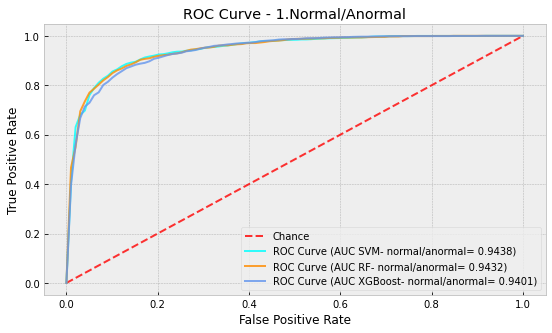

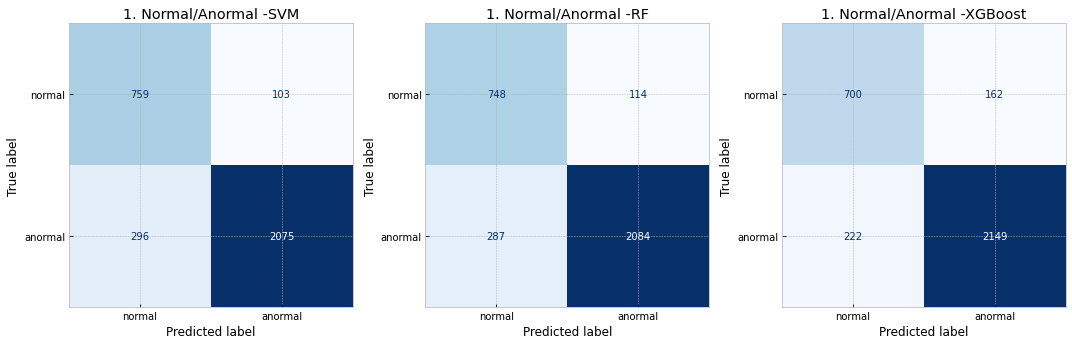

,Tipo,Model,Features,Acurácia,Precisão,Sensibil,Falso Pos,Especif,F1_measure
0,1- Normal/Anormal,SVM,Selected features to nucleus (MI),0.9123,0.9123,0.9123,0.0877,0.9123,0.9123
1,1- Normal/Anormal,RF,Selected features to nucleus (MI),0.9122,0.9122,0.9122,0.0878,0.9122,0.9122
2,1- Normal/Anormal,XGBoost,Selected features to nucleus (MI),0.9180,0.9180,0.9180,0.0820,0.9180,0.9180


In [38]:
# Exibe curvas roc, matrizes de confusão e métricas - Classificador binário:
functions.plot_roc_curve_CV(roc_curve_list_bin, labels_list_bin, title = "ROC Curve - 1.Normal/Anormal")
functions.plot_conf_matrix(preds_to_conf_matrix_bin, lbls=[0,1], disp_lbls=['normal', 'anormal'])
results_bin
    

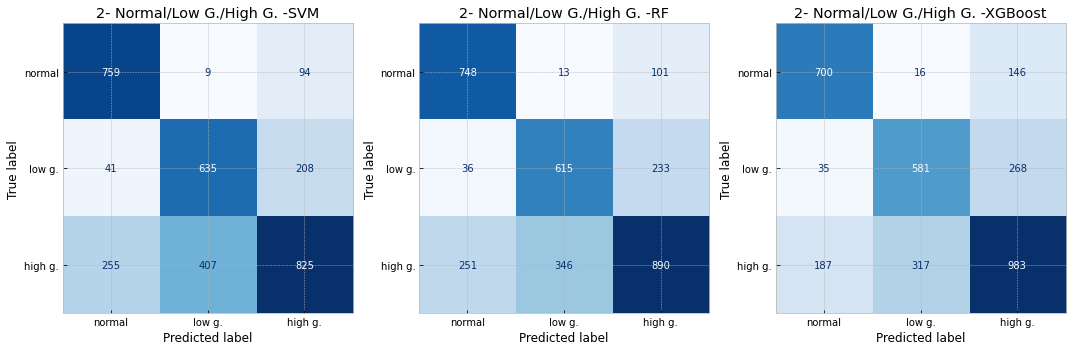

,Tipo,Model,Features,Acurácia,Precisão,Sensibil,Falso Pos,Especif,F1_measure
0,2- Normal/Low G./High G.,SVM,Selected features to nucleus (MI),0.6809,0.6809,0.6809,0.3191,0.6809,0.6809
1,2- Normal/Low G./High G.,RF,Selected features to nucleus (MI),0.6933,0.6933,0.6933,0.3067,0.6933,0.6933
2,2- Normal/Low G./High G.,XGBoost,Selected features to nucleus (MI),0.6995,0.6995,0.6995,0.3005,0.6995,0.6995


In [39]:
# Exibe matrizes de confusão e métricas - Classificador ternário:
functions.plot_conf_matrix(preds_to_conf_matrix_ter, lbls=[0,1,2], disp_lbls=['normal','low g.', 'high g.'])
results_ter


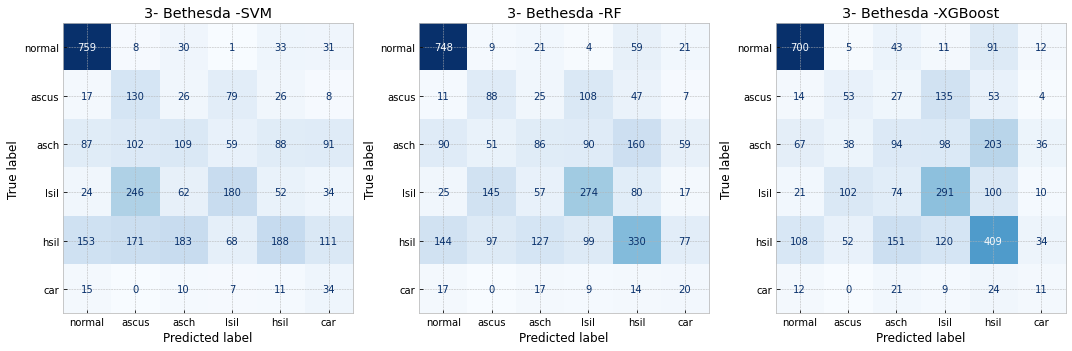

,Tipo,Model,Features,Acurácia,Precisão,Sensibil,Falso Pos,Especif,F1_measure
0,3- Bethesda,SVM,Selected features to nucleus (MI),0.4246,0.4246,0.4246,0.5754,0.4246,0.4246
1,3- Bethesda,RF,Selected features to nucleus (MI),0.4694,0.4694,0.4694,0.5306,0.4694,0.4694
2,3- Bethesda,XGBoost,Selected features to nucleus (MI),0.4739,0.4739,0.4739,0.5261,0.4739,0.4739


In [40]:
# Exibe matrizes de confusão e métricas - Classificador ternário:
functions.plot_conf_matrix(preds_to_conf_matrix_bet, lbls=[0,1,2,3,4,5], disp_lbls=['normal','ascus', 'asch', 'lsil', 'hsil', 'car'])
results_bet